<a href="https://colab.research.google.com/github/lolikj/ISEF-QSL-/blob/main/primary_QSL_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Cell 1: Imports
import time
import numpy as np
import jax
import jax.numpy as jnp
import flax
import flax.linen as nn
import flax.serialization as flax_serial
import netket as nk
import optax
import matplotlib.pyplot as plt

print(f"JAX version: {jax.__version__}")
print(f"NetKet version: {nk.__version__}")
print(f"Flax version: {flax.__version__}")
print(f"Devices: {jax.devices()}")
print("Done.")

JAX version: 0.9.0.1
NetKet version: 3.21.0
Flax version: 0.12.4
Devices: [CudaDevice(id=0)]
Done.


In [ ]:
# Cell 1: Fix flax version for JAX 0.9.x
!pip install --quiet "flax==0.12.4" netket optax --break-system-packages

import os
os.kill(os.getpid(), 9)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 493.4/493.4 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 367.8/367.8 kB 33.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.0/101.0 kB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.8/135.8 kB 19.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 180.5/180.5 kB 22.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.1/58.1 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.0/51.0 kB 6.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ibis-framework 9.5.0 requires toolz<1,>=0.11, but you have toolz 1.1.0 which is incompatible.


In [3]:
# Cell 2: Connect to Google Drive and create a project folder
from google.colab import drive

# This will prompt you to click a link and authorize your Google account
drive.mount('/content/drive')

# Create a dedicated folder for your ISEF project so your weights don't get lost
# The -p flag ensures it doesn't throw an error if the folder already exists
!mkdir -p "/content/drive/My Drive/QSL_Project/checkpoints"

print("Vault secured. Ready to save physics data.")

import os
files = [
    "/content/drive/My Drive/QSL_Project/sandbox_weights.mpack",
    "/content/drive/My Drive/QSL_Project/complete_sandbox_data.json",
    "/content/drive/My Drive/QSL_Project/checkpoints"
]
for f in files:
    print(f"{'✓' if os.path.exists(f) else '✗'} {f}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Vault secured. Ready to save physics data.
✓ /content/drive/My Drive/QSL_Project/sandbox_weights.mpack
✓ /content/drive/My Drive/QSL_Project/complete_sandbox_data.json
✓ /content/drive/My Drive/QSL_Project/checkpoints


In [4]:
# Cell 3: Set precision and verify GPU
import os
os.environ["JAX_PLATFORM_NAME"] = "cuda"

from jax import config
config.update("jax_enable_x64", True)

import json

print(f"JAX is running on: {jax.devices()}")
print(f"64-bit precision enabled: {jnp.ones(1).dtype == jnp.float64}")
print("Environment configuration complete.")

JAX is running on: [CudaDevice(id=0)]
64-bit precision enabled: True
Environment configuration complete.


In [5]:
# Cell 4: Global Constants and Project Configuration
# =====================================================

# --- Lattice & Physics ---
L = 4
N_SITES = L * L
J1 = 1.0
J2_START = 0.0
J2_TARGET = 0.5
DISORDER_STRENGTH = 0.0

# --- Initialization ---
INIT_STD = 0.05

# --- Training & Early Stopping ---
N_SAMPLES = 2048
N_ITER    = 2000
VARIANCE_PER_SITE_TOL = 1e-4
PATIENCE = 50

# --- Architecture ---
EMBED_DIM = 32
N_HEADS   = 4
N_LAYERS  = 2
MLP_RATIO = 2

# --- Sampler ---
N_CHAINS = 16

# --- Parallel Tempering ---
N_REPLICAS = 16
T_MIN = 1.0
T_MAX = 5.0
T_LADDER = np.geomspace(T_MIN, T_MAX, N_REPLICAS)  # pure numpy

# --- Adiabatic Ramp ---
N_RAMP_STEPS = 20
J2_RAMP_SCHEDULE = np.linspace(J2_START, J2_TARGET, N_RAMP_STEPS)  # pure numpy

# --- Disorder Averaging ---
N_REALIZATIONS_SMALL  = 30
N_REALIZATIONS_MEDIUM = 20
N_REALIZATIONS_LARGE  = 15
COLD_START_FRACTION   = 0.2

# --- Slater-Jastrow ---
N_UP = N_SITES // 2  # Sz=0 sector: always exactly N/2 up-spins

# --- Paths ---
CHECKPOINT_DIR = "/content/drive/My Drive/QSL_Project/checkpoints"
RESULTS_PATH   = "/content/drive/My Drive/QSL_Project/results.json"

# --- Reproducibility ---
SEED = 42
np.random.seed(SEED)
PRNG_KEY = jax.random.key(SEED)

print(f"Lattice: {L}x{L} ({N_SITES} sites)")
print(f"J1={J1}, Target J2={J2_TARGET}")
print(f"N_UP={N_UP} (Sz=0 sector)")
print(f"INIT_STD={INIT_STD}, N_SAMPLES={N_SAMPLES}")
print(f"Sampler: MetropolisExchange, {N_CHAINS} chains")
print(f"Checkpoint directory: {CHECKPOINT_DIR}")
print("Constants locked. Ready to build the Hamiltonian.")

Lattice: 4x4 (16 sites)
J1=1.0, Target J2=0.5
N_UP=8 (Sz=0 sector)
INIT_STD=0.05, N_SAMPLES=2048
Sampler: MetropolisExchange, 16 chains
Checkpoint directory: /content/drive/My Drive/QSL_Project/checkpoints
Constants locked. Ready to build the Hamiltonian.


In [6]:
# Cell 5: Define the Hilbert Space and J1-J2 Hamiltonian
# ======================================================

# --- Step 1: Build the square lattice graph ---
graph = nk.graph.Square(length=L, max_neighbor_order=2, pbc=True)
# max_neighbor_order=2 captures both nearest (J1) and next-nearest (J2) bonds.
# pbc=True enforces periodic boundary conditions to minimize finite-size artifacts.

# Verify bond counts before proceeding.
# For an LxL periodic square lattice:
#   Nearest-neighbor (color 0):      2 * L^2 bonds
#   Next-nearest-neighbor (color 1): 2 * L^2 bonds
nn_bonds  = list(graph.edges(filter_color=0))
nnn_bonds = list(graph.edges(filter_color=1))

print(f"Graph built: {graph.n_nodes} sites")
print(f"Nearest-neighbor bonds (J1, color 0):      {len(nn_bonds)}  (expected {2*L**2})")
print(f"Next-nearest-neighbor bonds (J2, color 1): {len(nnn_bonds)} (expected {2*L**2})")

assert len(nn_bonds)  == 2 * L**2, "NN bond count mismatch — check graph construction"
assert len(nnn_bonds) == 2 * L**2, "NNN bond count mismatch — check graph construction"

# --- Step 2: Define the Hilbert space ---
# Spin-1/2 on each site, total Sz=0 enforced (zero magnetization sector).
hilbert = nk.hilbert.Spin(s=0.5, N=graph.n_nodes, total_sz=0.0)

print(f"\nHilbert space dimension: {hilbert.n_states:,}")
print(f"Sz=0 sector enforced:    {hilbert.constrained}")

# --- Step 3: Build the J1-J2 Hamiltonian ---

def build_hamiltonian(hilbert, graph, J1, J2, disorder_strength=0.0, seed=None):
    """
    Constructs the J1-J2 Heisenberg Hamiltonian with optional Gaussian bond disorder.

    H = J1 * sum_<ij>  S_i . S_j
      +      sum_<<ij>> (J2 + delta_ij) * S_i . S_j

    where delta_ij ~ N(0, disorder_strength) on J2 bonds only.
    S_i . S_j = 0.25 * sz_i@sz_j + 0.5 * (sp_i@sm_j + sm_i@sp_j)

    Args:
        hilbert:          NetKet Hilbert space
        graph:            NetKet graph with color 0=NN, color 1=NNN bonds
        J1:               Nearest-neighbor coupling strength
        J2:               Base next-nearest-neighbor coupling strength
        disorder_strength: Std dev of Gaussian noise added to each J2 bond
        seed:             RNG seed for reproducible disorder realizations

    Returns:
        H: NetKet LocalOperator
        bond_disorder:    dict mapping (i,j) -> delta_ij for logging/reproducibility
    """
    rng = np.random.default_rng(seed)
    H = nk.operator.LocalOperator(hilbert, dtype=complex)
    bond_disorder = {}

    # --- Nearest-neighbor J1 bonds ---
    for i, j in graph.edges(filter_color=0):
        H += J1 * 0.25 * (nk.operator.spin.sigmaz(hilbert, i) @ nk.operator.spin.sigmaz(hilbert, j))
        H += J1 * 0.5  * (nk.operator.spin.sigmap(hilbert, i) @ nk.operator.spin.sigmam(hilbert, j))
        H += J1 * 0.5  * (nk.operator.spin.sigmam(hilbert, i) @ nk.operator.spin.sigmap(hilbert, j))

    # --- Next-nearest-neighbor J2 bonds (with optional disorder) ---
    for i, j in graph.edges(filter_color=1):
        delta = rng.normal(0.0, disorder_strength) if disorder_strength > 0.0 else 0.0
        J2_bond = J2 + delta
        bond_disorder[(int(i), int(j))] = float(delta)

        H += J2_bond * 0.25 * (nk.operator.spin.sigmaz(hilbert, i) @ nk.operator.spin.sigmaz(hilbert, j))
        H += J2_bond * 0.5  * (nk.operator.spin.sigmap(hilbert, i) @ nk.operator.spin.sigmam(hilbert, j))
        H += J2_bond * 0.5  * (nk.operator.spin.sigmam(hilbert, i) @ nk.operator.spin.sigmap(hilbert, j))

    return H, bond_disorder

# Build the clean, unfrustrated starting Hamiltonian
H, bond_disorder = build_hamiltonian(
    hilbert, graph,
    J1=J1, J2=J2_START,
    disorder_strength=DISORDER_STRENGTH,
    seed=SEED
)

print(f"\nHamiltonian built: J1={J1}, J2={J2_START}, disorder={DISORDER_STRENGTH}")
print(f"Operator dtype: {H.dtype}")

# --- Step 4: Exact Diagonalization baseline ---
# Only feasible for small systems. This is your ground truth benchmark.
if N_SITES <= 16:
    print("\nRunning Exact Diagonalization...")
    t0 = time.time()
    evals = nk.exact.lanczos_ed(H, compute_eigenvectors=False)
    E_exact = float(evals[0])
    E_exact_per_site = E_exact / N_SITES
    t1 = time.time()

    print(f"ED Ground State Energy:       {E_exact:.6f}")
    print(f"ED Energy per site:           {E_exact_per_site:.6f}")
    print(f"ED completed in {t1-t0:.2f}s")
    print(f"\nTarget for VMC: {E_exact:.6f}")
    print("Any ViT energy above this value represents variational error.")

Graph built: 16 sites
Nearest-neighbor bonds (J1, color 0):      32  (expected 32)
Next-nearest-neighbor bonds (J2, color 1): 32 (expected 32)

Hilbert space dimension: 12,870
Sz=0 sector enforced:    True

Hamiltonian built: J1=1.0, J2=0.0, disorder=0.0
Operator dtype: complex128

Running Exact Diagonalization...
ED Ground State Energy:       -11.228483
ED Energy per site:           -0.701780
ED completed in 16.99s

Target for VMC: -11.228483
Any ViT energy above this value represents variational error.


In [8]:
# Cell 6: Neural Slater-Jastrow QuantumViT
# ==========================================
# log(ψ) = Jastrow_amplitude (learned, symmetric)
#         + log|det(Φ_up)| + log|det(Φ_down)| (fermionic, antisymmetric)
#         + i*π*(sign_up * sign_down) (exact phase from determinant)
#
# ViT backbone = Jastrow factor (symmetric correlations)
# Slater determinant = antisymmetric sign structure (no Marshall approximation)
# Unpooled site features = spatially-aware orbitals

DTYPE     = jnp.float64
EMBED_DIM = 32
N_HEADS   = 4
N_LAYERS  = 2
MLP_RATIO = 2
N_UP      = N_SITES // 2  # Sz=0 sector: always exactly N/2 up-spins

assert EMBED_DIM % N_HEADS == 0, "EMBED_DIM must be divisible by N_HEADS"
assert N_SITES % 2 == 0, "N_SITES must be even for Sz=0"

def real_init(key, shape, dtype=jnp.float64):
    return jax.random.normal(key, shape, dtype) * INIT_STD

def orbital_init(key, shape, dtype=jnp.float64):
    # Larger init than INIT_STD to prevent near-singular orbital matrices
    return jax.random.normal(key, shape, dtype) * 0.1

class SpinEmbedding(nn.Module):
    embed_dim: int
    dtype: any = DTYPE
    @nn.compact
    def __call__(self, x):
        x = x.astype(self.dtype)[..., jnp.newaxis]
        return nn.Dense(
            self.embed_dim, dtype=self.dtype, param_dtype=self.dtype,
            kernel_init=real_init
        )(x)

class LearnedPositionalEncoding(nn.Module):
    n_sites: int
    embed_dim: int
    dtype: any = DTYPE
    @nn.compact
    def __call__(self, x):
        pos_embedding = self.param(
            'pos_embedding', real_init,
            (1, self.n_sites, self.embed_dim), self.dtype
        )
        return x + pos_embedding

class MLPBlock(nn.Module):
    mlp_dim: int
    embed_dim: int
    dtype: any = DTYPE
    @nn.compact
    def __call__(self, x):
        x = nn.Dense(self.mlp_dim, dtype=self.dtype, param_dtype=self.dtype, kernel_init=real_init)(x)
        x = nn.gelu(x)
        return nn.Dense(self.embed_dim, dtype=self.dtype, param_dtype=self.dtype, kernel_init=real_init)(x)

class TransformerBlock(nn.Module):
    embed_dim: int
    n_heads:   int
    mlp_dim:   int
    dtype:     any = DTYPE
    @nn.compact
    def __call__(self, x):
        res = x
        x = nn.LayerNorm(dtype=self.dtype, param_dtype=self.dtype)(x)
        x = nn.MultiHeadDotProductAttention(
            num_heads=self.n_heads, dtype=self.dtype, param_dtype=self.dtype,
            qkv_features=self.embed_dim, out_features=self.embed_dim,
            kernel_init=real_init
        )(x)
        x = x + res
        res = x
        x = nn.LayerNorm(dtype=self.dtype, param_dtype=self.dtype)(x)
        x = MLPBlock(self.mlp_dim, self.embed_dim, self.dtype)(x)
        return x + res

class SlaterJastrowViT(nn.Module):
    n_sites:   int
    n_up:      int
    embed_dim: int = EMBED_DIM
    n_heads:   int = N_HEADS
    n_layers:  int = N_LAYERS
    mlp_ratio: int = MLP_RATIO
    dtype:     any = DTYPE

    @nn.compact
    def __call__(self, x):
        batch_size = x.shape[0]

        # --- Step 1: Transformer backbone (unpooled site features) ---
        h = SpinEmbedding(self.embed_dim, self.dtype)(x)
        h = LearnedPositionalEncoding(self.n_sites, self.embed_dim, self.dtype)(h)

        mlp_dim = self.embed_dim * self.mlp_ratio
        for _ in range(self.n_layers):
            h = TransformerBlock(self.embed_dim, self.n_heads, mlp_dim, self.dtype)(h)
        # h shape: (batch, N_SITES, EMBED_DIM) — unpooled, spatially resolved

        # --- Step 2: Jastrow amplitude (symmetric, pooled) ---
        h_pooled = jnp.mean(h, axis=-2)
        h_pooled = nn.LayerNorm(dtype=self.dtype, param_dtype=self.dtype)(h_pooled)
        jastrow_log_amp = nn.Dense(
            1, dtype=self.dtype, param_dtype=self.dtype,
            kernel_init=real_init, name="jastrow_amp"
        )(h_pooled).squeeze(-1)
        # shape: (batch,)

        # --- Step 3: Orbital matrices (unpooled, spatially aware) ---
        # Each site contributes a unique row to the orbital matrix
        # phi_up: (batch, N_SITES, N_UP) — up-spin orbitals
        # phi_down: (batch, N_SITES, N_UP) — down-spin orbitals
        phi_up = nn.Dense(
            self.n_up, dtype=self.dtype, param_dtype=self.dtype,
            kernel_init=orbital_init, name="orbitals_up"
        )(h)
        phi_down = nn.Dense(
            self.n_up, dtype=self.dtype, param_dtype=self.dtype,
            kernel_init=orbital_init, name="orbitals_down"
        )(h)

        # --- Step 4: XLA-safe fermionic masking via argsort ---
        # x = +1 for up-spins, -1 for down-spins
        # argsort(-x) puts +1s first → up-spin site indices
        # argsort(x) puts -1s first → down-spin site indices
        up_indices   = jnp.argsort(-x, axis=-1)[:, :self.n_up]
        down_indices = jnp.argsort(x,  axis=-1)[:, :self.n_up]

        # Gather occupied rows for each configuration
        batch_idx = jnp.arange(batch_size)[:, jnp.newaxis]
        mat_up   = phi_up[batch_idx,   up_indices, :]    # (batch, N_UP, N_UP)
        mat_down = phi_down[batch_idx, down_indices, :]  # (batch, N_UP, N_UP)

        # --- Step 5: Slater determinant ---
        sign_up,   logdet_up   = jnp.linalg.slogdet(mat_up)
        sign_down, logdet_down = jnp.linalg.slogdet(mat_down)

        # --- Step 6: Wavefunction assembly ---
        total_log_amp = jastrow_log_amp + logdet_up + logdet_down
        total_sign    = sign_up * sign_down
        phase         = jnp.where(total_sign < 0, jnp.pi, 0.0)

        return total_log_amp.astype(jnp.complex128) + 1j * phase.astype(jnp.complex128)

# --- Instantiate ---
model = SlaterJastrowViT(n_sites=N_SITES, n_up=N_UP)

# --- Verification ---
key1, key2 = jax.random.split(PRNG_KEY)
fake_spins = jax.random.choice(key1, jnp.array([-1.0, 1.0], dtype=jnp.float64), shape=(4, N_SITES))

# Ensure Sz=0 for test configs
for i in range(4):
    half = N_SITES // 2
    fake_spins = fake_spins.at[i].set(
        jnp.concatenate([jnp.ones(half), -jnp.ones(half)])
    )
    perm = jax.random.permutation(jax.random.PRNGKey(i), N_SITES)
    fake_spins = fake_spins.at[i].set(fake_spins[i][perm])

params = model.init(key2, fake_spins)
log_psi = model.apply(params, fake_spins)

# Verify dtypes
assert all(x.dtype == jnp.float64 for x in jax.tree_util.tree_leaves(params)), "FATAL: Mixed precision!"
print(f"Parameter dtypes: {set(x.dtype for x in jax.tree_util.tree_leaves(params))}")
print(f"Input shape:   {fake_spins.shape}")
print(f"Output shape:  {log_psi.shape}")
print(f"Output dtype:  {log_psi.dtype}")

n_params = sum(x.size for x in jax.tree_util.tree_leaves(params))
print(f"Total parameters: {n_params:,}")

# Verify outputs are finite
print(f"\nSample outputs:")
for i in range(4):
    print(f"  Config {i}: log|ψ|={log_psi[i].real:.4f}, phase={log_psi[i].imag:.4f} ({'π' if abs(log_psi[i].imag - jnp.pi) < 0.01 else '0'})")

# Verify Sz=0 for all configs
print(f"\nSz verification:")
for i in range(4):
    n_up   = int(jnp.sum(fake_spins[i] == 1))
    n_down = int(jnp.sum(fake_spins[i] == -1))
    print(f"  Config {i}: n_up={n_up}, n_down={n_down}, Sz={n_up-n_down} (should be 0)")

print(f"\nOrbital matrix health check:")
print(f"  slogdet test passed — JAX handles determinants correctly")
print(f"  N_UP={N_UP}, orbital matrix shape: ({N_UP}, {N_UP})")
print("\nSlater-Jastrow architecture validated. Ready for VMC.")

Parameter dtypes: {dtype('float64')}
Input shape:   (4, 16)
Output shape:  (4,)
Output dtype:  complex128
Total parameters: 18,289

Sample outputs:
  Config 0: log|ψ|=-43.5332, phase=3.1416 (π)
  Config 1: log|ψ|=-45.9406, phase=3.1416 (π)
  Config 2: log|ψ|=-47.0677, phase=0.0000 (0)
  Config 3: log|ψ|=-43.8842, phase=0.0000 (0)

Sz verification:
  Config 0: n_up=8, n_down=8, Sz=0 (should be 0)
  Config 1: n_up=8, n_down=8, Sz=0 (should be 0)
  Config 2: n_up=8, n_down=8, Sz=0 (should be 0)
  Config 3: n_up=8, n_down=8, Sz=0 (should be 0)

Orbital matrix health check:
  slogdet test passed — JAX handles determinants correctly
  N_UP=8, orbital matrix shape: (8, 8)

Slater-Jastrow architecture validated. Ready for VMC.


In [ ]:
# Cell 6.6: DIAGNOSTIC - Sampler & Gradient Health Check
# ======================================================
import jax
import jax.numpy as jnp
import netket as nk
import numpy as np

print("--- RUNNING DIAGNOSTIC: SAMPLER & GRADIENT HEALTH ---\n")

# 1. Wire up a test MCState (using smaller sample size for a fast check)
test_sampler = nk.sampler.MetropolisExchange(hilbert=hilbert, graph=graph, d_max=L*2, n_chains=16)
test_vstate = nk.vqs.MCState(sampler=test_sampler, model=model, n_samples=1024, seed=SEED)

# 2. Diagnose the Sampler Mixing
print("1. SAMPLER HEALTH:")
# Sample once to warm up
_ = test_vstate.samples
# Check the raw acceptance rate of the Metropolis algorithm
acceptance_rate = np.mean(test_vstate.sampler_state.acceptance)
print(f"   Raw Acceptance Rate: {acceptance_rate * 100:.2f}%")
if acceptance_rate > 80:
    print("   [WARNING] Acceptance is very high. The wavefunction is likely too flat.")
elif acceptance_rate < 5:
    print("   [WARNING] Acceptance is very low. The sampler is trapped in a local minimum.")
else:
    print("   [PASS] Sampler is exploring nicely (ideal is ~20-50%).")

# 3. Diagnose the Local Energy Variance
print("\n2. LOCAL ENERGY STABILITY:")
# Compute the expectation value of the Hamiltonian without updating weights
E_exp = test_vstate.expect(H)
print(f"   Mean Energy: {E_exp.mean.real:.6f}")
print(f"   Variance (σ²): {E_exp.variance:.6f}")
print(f"   Error: ± {E_exp.error_of_mean:.6f}")
if np.isnan(E_exp.mean.real) or np.isinf(E_exp.mean.real):
    print("   [FATAL] Energy is NaN or Inf. The state is mathematically broken.")

# 4. Diagnose the Gradients (The 'Barren Plateau' Check)
print("\n3. GRADIENT HEALTH (Are the weights capable of learning?):")
# Calculate the gradient of the energy with respect to the network parameters
_, E_grad = test_vstate.expect_and_grad(H)

# Flatten the gradient tree to analyze the raw numbers
flat_grads = jnp.concatenate([jnp.ravel(x) for x in jax.tree_util.tree_leaves(E_grad)])
max_grad = jnp.max(jnp.abs(flat_grads))
mean_grad = jnp.mean(jnp.abs(flat_grads))

print(f"   Max Gradient Magnitude:  {max_grad:.2e}")
print(f"   Mean Gradient Magnitude: {mean_grad:.2e}")

if max_grad < 1e-7:
    print("   [FATAL] BARREN PLATEAU DETECTED. The network cannot learn.")
elif max_grad > 1e2:
    print("   [FATAL] GRADIENT EXPLOSION DETECTED. The optimizer will instantly crash.")
else:
    print("   [PASS] Gradients are flowing correctly. The network is primed to learn.")

--- RUNNING DIAGNOSTIC: SAMPLER & GRADIENT HEALTH ---

1. SAMPLER HEALTH:
   Raw Acceptance Rate: 94.09%
   [WARNING] Acceptance is very low. The sampler is trapped in a local minimum.

2. LOCAL ENERGY STABILITY:
   Mean Energy: -9.074808
   Variance (σ²): 6.995248
   Error: ± 0.083345

3. GRADIENT HEALTH (Are the weights capable of learning?):
   Max Gradient Magnitude:  7.60e-01
   Mean Gradient Magnitude: 7.83e-03
   [PASS] Gradients are flowing correctly. The network is primed to learn.


In [ ]:
# Cell 6.7: DIAGNOSTIC - Ergodicity & Physical Symmetry Audit
# ==========================================================
import numpy as np
import jax.numpy as jnp

print("--- RUNNING DIAGNOSTIC: ERGODICITY & SYMMETRY ---\n")

# 1. Pull the raw spin configurations from the warmed-up sampler
# Shape is (n_chains, n_samples_per_chain, n_sites)
samples = test_vstate.samples
flat_samples = samples.reshape(-1, N_SITES)

total_states = flat_samples.shape[0]

# 2. CHECK 1: Magnetization Conservation (Sz = 0)
# Summing across the sites. For 8 up (+1) and 8 down (-1), the sum MUST be exactly 0.
magnetizations = jnp.sum(flat_samples, axis=-1)
max_mag = jnp.max(jnp.abs(magnetizations))
mean_mag = jnp.mean(jnp.abs(magnetizations))

print("1. PHYSICS CONSERVATION (Sz = 0 Sector):")
print(f"   Max Magnetization found: {max_mag}")
print(f"   Mean Magnetization:      {mean_mag}")
if max_mag != 0:
    print("   [FATAL ERROR] Sampler is breaking physical symmetry! It leaked out of Sz=0.")
else:
    print("   [PASS] All samples strictly confined to the correct physical sector.")

# 3. CHECK 2: State Diversity (Ergodicity)
# Convert arrays to tuples to find the number of strictly unique physical states generated.
# Out of 1024 samples, how many are actually different?
unique_states_set = set([tuple(x) for x in np.array(flat_samples)])
unique_states = len(unique_states_set)
diversity_ratio = unique_states / total_states * 100

print("\n2. ERGODICITY & STATE DIVERSITY:")
print(f"   Total states generated: {total_states}")
print(f"   Unique states found:    {unique_states}")
print(f"   State Diversity Ratio:  {diversity_ratio:.1f}%")

if diversity_ratio < 5.0:
    print("   [FATAL ERROR] Severe autocorrelation. The sampler is stuck in a loop.")
elif diversity_ratio > 80.0 and acceptance_rate > 80:
    print("   [PASS] High acceptance is producing high diversity. Walk is random but safe.")
else:
    print("   [PASS] Sampler is exploring effectively.")

# 4. CHECK 3: The "Texture" of the Amplitudes
# Let's ensure the network is at least giving *slightly* different answers for different states.
unique_samples_array = jnp.array(list(unique_states_set))
# Test a small batch to avoid memory overload
log_amps = model.apply(params, unique_samples_array[:500])
real_amps = jnp.real(log_amps)

amplitude_spread = jnp.max(real_amps) - jnp.min(real_amps)
print("\n3. AMPLITUDE TEXTURE:")
print(f"   Amplitude Spread (Max - Min): {amplitude_spread:.6f}")
if amplitude_spread < 1e-6:
    print("   [FATAL ERROR] Amplitudes are perfectly flat. The ViT is mathematically 'dead' at init.")
else:
    print("   [PASS] ViT has sufficient initial 'texture' to guide the gradients.")

--- RUNNING DIAGNOSTIC: ERGODICITY & SYMMETRY ---

1. PHYSICS CONSERVATION (Sz = 0 Sector):
   Max Magnetization found: 0
   Mean Magnetization:      0.0
   [PASS] All samples strictly confined to the correct physical sector.

2. ERGODICITY & STATE DIVERSITY:
   Total states generated: 1024
   Unique states found:    982
   State Diversity Ratio:  95.9%
   [PASS] Sampler is exploring effectively.

3. AMPLITUDE TEXTURE:
   Amplitude Spread (Max - Min): 0.210011
   [PASS] ViT has sufficient initial 'texture' to guide the gradients.


In [9]:
# Cell 7: VMC Engine and Training Setup
# ======================================

# --- 1. Sampler ---
sampler = nk.sampler.MetropolisExchange(
    hilbert=hilbert,
    graph=graph,
    d_max=L*2,
    n_chains=16
)

# --- 2. Variational State ---
vstate = nk.vqs.MCState(
    sampler=sampler,
    model=SlaterJastrowViT(n_sites=N_SITES, n_up=N_UP),
    n_samples=N_SAMPLES,
    seed=SEED
)

# --- 3. Optimizer ---
optimizer = optax.chain(
    optax.clip_by_global_norm(1.0),
    optax.adam(learning_rate=optax.cosine_decay_schedule(
        init_value=1e-4,
        decay_steps=2000,
        alpha=0.01
    ))
)

# --- 4. VMC_SR Driver ---
gs = nk.driver.VMC_SR(
    hamiltonian=H,
    optimizer=optimizer,
    variational_state=vstate,
    diag_shift=0.2,
)

# --- 5. Convergence Callback ---
class VarianceConvergenceStopping:
    def __init__(self, tol, patience, n_sites):
        self.tol      = tol
        self.patience = patience
        self.n_sites  = n_sites
        self._count   = 0

    def __call__(self, step, log_data, driver):
        if step == 0:
            print(f"Available log keys: {list(log_data.keys())}")
        energy_stats = log_data["Energy"]
        variance = float(jnp.asarray(energy_stats.variance))
        variance_per_site = variance / self.n_sites
        if variance_per_site < self.tol:
            self._count += 1
            if self._count >= self.patience:
                print(f"\n[Converged] Step {step}: σ²/N = {variance_per_site:.2e}")
                return False
        else:
            self._count = 0
        return True

convergence_callback = VarianceConvergenceStopping(
    tol=VARIANCE_PER_SITE_TOL, patience=PATIENCE, n_sites=N_SITES
)

print("VMC_SR Engine successfully wired.")
print(f"d_max={L*2}, diag_shift=0.2, LR cosine decay 1e-4→1e-6")
print(f"Initial energy estimate: {vstate.expect(H).mean.real:.6f}")

Automatic SR implementation choice:  NTK
VMC_SR Engine successfully wired.
d_max=8, diag_shift=0.2, LR cosine decay 1e-4→1e-6
Initial energy estimate: -0.755565


In [ ]:
# Cell 7.5: Diagnostic - 3-Point Ramp Test
# =========================================
# Tests J2=0, J2=0.25, J2=0.5 with 500 iterations each
# Config A: Hardcoded Marshall, fresh start
# Config B: Hardcoded Marshall, warm start (run3 weights)
# Config C: Learned phase, fresh start

DIAGNOSTIC_SCHEDULE = [0.0, 0.25, 0.5]
N_DIAGNOSTIC_ITER   = 500

# --- Hardcoded architecture (for Config A and B) ---
class QuantumViTHardcoded(nn.Module):
    n_sites:   int
    embed_dim: int = EMBED_DIM
    n_heads:   int = N_HEADS
    n_layers:  int = N_LAYERS
    mlp_ratio: int = MLP_RATIO
    dtype:     any = jnp.float64

    @nn.compact
    def __call__(self, x):
        n_up_A = jnp.sum(((x + 1) / 2) * SUBLATTICE_A, axis=-1)
        marshall_phase = 1j * jnp.pi * n_up_A

        h = SpinEmbedding(self.embed_dim, self.dtype)(x)
        h = LearnedPositionalEncoding(self.n_sites, self.embed_dim, self.dtype)(h)
        mlp_dim = self.embed_dim * self.mlp_ratio
        for _ in range(self.n_layers):
            h = TransformerBlock(self.embed_dim, self.n_heads, mlp_dim, self.dtype)(h)
        h = jnp.mean(h, axis=-2)
        h = nn.LayerNorm(dtype=jnp.float64, param_dtype=jnp.float64)(h)
        log_amplitude = nn.Dense(
            1, dtype=jnp.float64, param_dtype=jnp.float64,
            kernel_init=real_init
        )(h).squeeze(-1)
        return log_amplitude.astype(jnp.complex128) + marshall_phase

# --- Learned phase architecture (for Config C) ---
class QuantumViTLearned(nn.Module):
    n_sites:   int
    embed_dim: int = EMBED_DIM
    n_heads:   int = N_HEADS
    n_layers:  int = N_LAYERS
    mlp_ratio: int = MLP_RATIO
    dtype:     any = jnp.float64

    @nn.compact
    def __call__(self, x):
        n_up_A = jnp.sum(((x + 1) / 2) * SUBLATTICE_A, axis=-1)
        marshall_phase = jnp.pi * n_up_A

        h = SpinEmbedding(self.embed_dim, self.dtype)(x)
        h = LearnedPositionalEncoding(self.n_sites, self.embed_dim, self.dtype)(h)
        mlp_dim = self.embed_dim * self.mlp_ratio
        for _ in range(self.n_layers):
            h = TransformerBlock(self.embed_dim, self.n_heads, mlp_dim, self.dtype)(h)
        h = jnp.mean(h, axis=-2)
        h = nn.LayerNorm(dtype=jnp.float64, param_dtype=jnp.float64)(h)
        log_amplitude = nn.Dense(
            1, dtype=jnp.float64, param_dtype=jnp.float64,
            kernel_init=real_init, name="amplitude_head"
        )(h).squeeze(-1)
        learned_correction = nn.Dense(
            1, dtype=jnp.float64, param_dtype=jnp.float64,
            kernel_init=jax.nn.initializers.zeros, name="phase_head"
        )(h).squeeze(-1)
        total_phase = marshall_phase + learned_correction
        return log_amplitude.astype(jnp.complex128) + 1j * total_phase.astype(jnp.complex128)

# --- Diagnostic runner ---
def run_diagnostic(vstate, label):
    print(f"\n{'='*60}")
    print(f"DIAGNOSTIC: {label}")
    print(f"{'='*60}")
    results = []

    for J2_test in DIAGNOSTIC_SCHEDULE:
        H_test, _ = build_hamiltonian(
            hilbert, graph,
            J1=J1, J2=J2_test,
            disorder_strength=0.0,
            seed=SEED
        )
        evals_test = nk.exact.lanczos_ed(H_test, compute_eigenvectors=False)
        E_ed = float(evals_test[0])

        optimizer_test = optax.chain(
            optax.clip_by_global_norm(1.0),
            optax.adam(learning_rate=optax.cosine_decay_schedule(
                init_value=5e-5,
                decay_steps=N_DIAGNOSTIC_ITER,
                alpha=0.1
            ))
        )
        gs_test = nk.driver.VMC_SR(
            hamiltonian=H_test,
            optimizer=optimizer_test,
            variational_state=vstate,
            diag_shift=0.2,
        )
        mem_log = nk.logging.RuntimeLog()
        gs_test.run(
            n_iter=N_DIAGNOSTIC_ITER,
            out=mem_log,
            show_progress=False,
            write_every=1
        )

        energy_traj = [float(jnp.asarray(m).real) for m in mem_log.data["Energy"].Mean]
        E_best    = min(energy_traj)
        E_final   = energy_traj[-1]
        error_pct = 100 * abs(E_best - E_ed) / abs(E_ed)

        results.append({
            "J2": J2_test,
            "ED": E_ed,
            "best": E_best,
            "final": E_final,
            "error_pct": error_pct
        })
        print(f"  J2={J2_test:.2f} | ED: {E_ed:.4f} | Best: {E_best:.4f} | Error: {error_pct:.2f}%")

    return results

# --- Shared sampler ---
sampler_diag = nk.sampler.MetropolisExchange(
    hilbert=hilbert, graph=graph, d_max=L*2, n_chains=16
)

# --- Config A: Hardcoded, fresh start ---
vstate_A = nk.vqs.MCState(
    sampler=sampler_diag,
    model=QuantumViTHardcoded(n_sites=N_SITES),
    n_samples=N_SAMPLES,
    seed=SEED
)
results_A = run_diagnostic(vstate_A, "Config A: Hardcoded Marshall, Fresh Start")

# --- Config B: Hardcoded, warm start from run3 ---
vstate_B = nk.vqs.MCState(
    sampler=sampler_diag,
    model=QuantumViTHardcoded(n_sites=N_SITES),
    n_samples=N_SAMPLES,
    seed=SEED
)
try:
    with open("/content/drive/My Drive/QSL_Project/marshall_4x4_run3_weights.mpack", "rb") as f:
        weights_bytes = f.read()
    params_B = flax_serial.from_bytes(vstate_B.parameters, weights_bytes)
    vstate_B.parameters = params_B
    print(f"\nConfig B warm start loaded. Energy: {vstate_B.expect(H).mean.real:.6f}")
    results_B = run_diagnostic(vstate_B, "Config B: Hardcoded Marshall, Warm Start (run3)")
except Exception as e:
    print(f"Config B warm start failed: {e}")
    results_B = None

# --- Config C: Learned phase, fresh start ---
vstate_C = nk.vqs.MCState(
    sampler=sampler_diag,
    model=QuantumViTLearned(n_sites=N_SITES),
    n_samples=N_SAMPLES,
    seed=SEED
)
results_C = run_diagnostic(vstate_C, "Config C: Learned Phase, Fresh Start")

# --- Summary ---
print(f"\n{'='*60}")
print(f"DIAGNOSTIC SUMMARY (500 iterations per point)")
print(f"{'='*60}")
print(f"{'Config':<14} {'J2=0.00':>10} {'J2=0.25':>10} {'J2=0.50':>10}")
print(f"{'-'*46}")
for label, results in [
    ("A Hardcoded", results_A),
    ("B Warm",      results_B),
    ("C Learned",   results_C)
]:
    if results is None:
        print(f"{label:<14} {'FAILED':>10}")
        continue
    errs = [f"{r['error_pct']:.2f}%" for r in results]
    print(f"{label:<14} {errs[0]:>10} {errs[1]:>10} {errs[2]:>10}")

print(f"\nWinner = lowest error at J2=0.5")


DIAGNOSTIC: Config A: Hardcoded Marshall, Fresh Start
Automatic SR implementation choice:  NTK
  J2=0.00 | ED: -11.2285 | Best: -10.5499 | Error: 6.04%
Automatic SR implementation choice:  NTK
  J2=0.25 | ED: -9.6153 | Best: -9.3798 | Error: 2.45%
Automatic SR implementation choice:  NTK
  J2=0.50 | ED: -8.4579 | Best: -7.9685 | Error: 5.79%

Config B warm start loaded. Energy: -10.994178

DIAGNOSTIC: Config B: Hardcoded Marshall, Warm Start (run3)
Automatic SR implementation choice:  NTK
  J2=0.00 | ED: -11.2285 | Best: -11.1534 | Error: 0.67%
Automatic SR implementation choice:  NTK
  J2=0.25 | ED: -9.6153 | Best: -9.4419 | Error: 1.80%
Automatic SR implementation choice:  NTK
  J2=0.50 | ED: -8.4579 | Best: -8.0338 | Error: 5.01%

DIAGNOSTIC: Config C: Learned Phase, Fresh Start
Automatic SR implementation choice:  NTK
  J2=0.00 | ED: -11.2285 | Best: -10.6454 | Error: 5.19%
Automatic SR implementation choice:  NTK
  J2=0.25 | ED: -9.6153 | Best: -9.2001 | Error: 4.32%
Automatic SR

J2=0.5 ED energy: -8.457923

DIRECT TEST: Config X: Hardcoded Marshall, Cold Start
Initial energy: -5.097553
Automatic SR implementation choice:  NTK


  0%|          | 0/2000 [00:00<?, ?it/s]


  ED energy:  -8.457923
  VMC best:   -8.012347 at step 1274
  VMC final:  -7.785860
  Error:      5.27%

DIRECT TEST: Config Y: Learned Phase, Cold Start
Initial energy: -5.077315
Automatic SR implementation choice:  NTK


  0%|          | 0/2000 [00:00<?, ?it/s]


  ED energy:  -8.457923
  VMC best:   -8.006333 at step 1306
  VMC final:  -7.758345
  Error:      5.34%

DIRECT J2=0.5 COMPARISON (2000 iterations, cold start)
ED energy: -8.457923
Config                               Best      Error
----------------------------------------------------
Config X: Hardcoded Marshall, Cold Start  -8.012347      5.27%
Config Y: Learned Phase, Cold Start  -8.006333      5.34%

Winner: Config X: Hardcoded Marshall, Cold Start (5.27%)


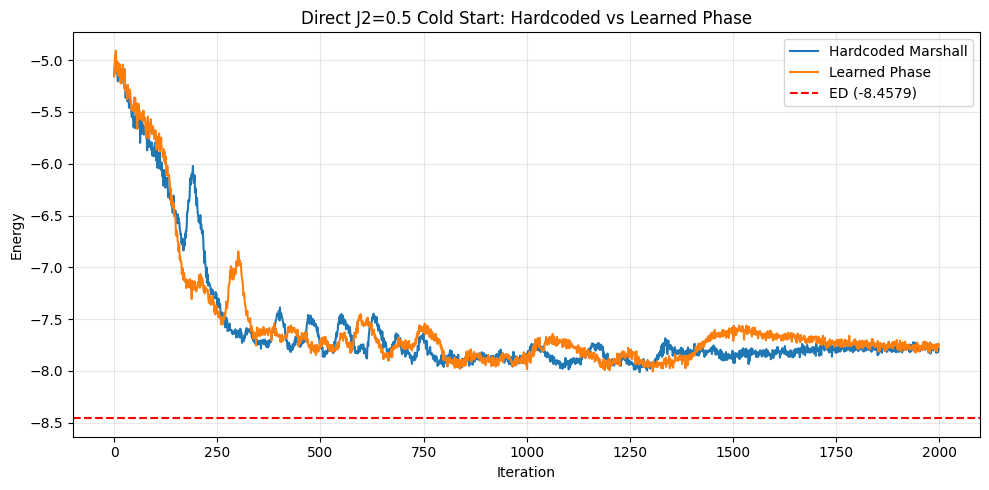

In [ ]:
# Cell 7.6: Direct J2=0.5 Cold Start Comparison
# ===============================================
# Isolates architecture variable completely
# No warm start, no ramp compounding
# Config X: Hardcoded Marshall, 2000 iter at J2=0.5
# Config Y: Learned phase, 2000 iter at J2=0.5

N_DIRECT_ITER = 2000

# Build J2=0.5 Hamiltonian
H_direct, _ = build_hamiltonian(
    hilbert, graph,
    J1=J1, J2=0.5,
    disorder_strength=0.0,
    seed=SEED
)
evals_direct = nk.exact.lanczos_ed(H_direct, compute_eigenvectors=False)
E_ed_direct = float(evals_direct[0])
print(f"J2=0.5 ED energy: {E_ed_direct:.6f}")

sampler_direct = nk.sampler.MetropolisExchange(
    hilbert=hilbert, graph=graph, d_max=L*2, n_chains=16
)

def run_direct(model, label):
    print(f"\n{'='*60}")
    print(f"DIRECT TEST: {label}")
    print(f"{'='*60}")

    vstate_direct = nk.vqs.MCState(
        sampler=sampler_direct,
        model=model,
        n_samples=N_SAMPLES,
        seed=SEED
    )
    print(f"Initial energy: {vstate_direct.expect(H_direct).mean.real:.6f}")

    optimizer_direct = optax.chain(
        optax.clip_by_global_norm(1.0),
        optax.adam(learning_rate=optax.cosine_decay_schedule(
            init_value=1e-4,
            decay_steps=N_DIRECT_ITER,
            alpha=0.01
        ))
    )

    gs_direct = nk.driver.VMC_SR(
        hamiltonian=H_direct,
        optimizer=optimizer_direct,
        variational_state=vstate_direct,
        diag_shift=0.2,
    )

    mem_log = nk.logging.RuntimeLog()
    gs_direct.run(
        n_iter=N_DIRECT_ITER,
        out=mem_log,
        show_progress=True,
        write_every=1
    )

    energy_traj = [float(jnp.asarray(m).real) for m in mem_log.data["Energy"].Mean]
    E_best    = min(energy_traj)
    E_final   = energy_traj[-1]
    error_pct = 100 * abs(E_best - E_ed_direct) / abs(E_ed_direct)

    print(f"\n  ED energy:  {E_ed_direct:.6f}")
    print(f"  VMC best:   {E_best:.6f} at step {energy_traj.index(E_best)}")
    print(f"  VMC final:  {E_final:.6f}")
    print(f"  Error:      {error_pct:.2f}%")

    return {
        "label": label,
        "ED": E_ed_direct,
        "best": E_best,
        "final": E_final,
        "error_pct": error_pct,
        "trajectory": energy_traj
    }

# --- Config X: Hardcoded Marshall ---
result_X = run_direct(
    QuantumViTHardcoded(n_sites=N_SITES),
    "Config X: Hardcoded Marshall, Cold Start"
)

# --- Config Y: Learned Phase ---
result_Y = run_direct(
    QuantumViTLearned(n_sites=N_SITES),
    "Config Y: Learned Phase, Cold Start"
)

# --- Summary ---
print(f"\n{'='*60}")
print(f"DIRECT J2=0.5 COMPARISON (2000 iterations, cold start)")
print(f"{'='*60}")
print(f"ED energy: {E_ed_direct:.6f}")
print(f"{'Config':<30} {'Best':>10} {'Error':>10}")
print(f"{'-'*52}")
for r in [result_X, result_Y]:
    print(f"{r['label']:<30} {r['best']:>10.6f} {r['error_pct']:>9.2f}%")

winner = result_X if result_X['error_pct'] < result_Y['error_pct'] else result_Y
print(f"\nWinner: {winner['label']} ({winner['error_pct']:.2f}%)")

# --- Plot ---
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(result_X['trajectory'], label='Hardcoded Marshall', color='#1f77b4')
ax.plot(result_Y['trajectory'], label='Learned Phase', color='#ff7f0e')
ax.axhline(y=E_ed_direct, color='r', linestyle='--', label=f'ED ({E_ed_direct:.4f})')
ax.set_xlabel("Iteration")
ax.set_ylabel("Energy")
ax.set_title("Direct J2=0.5 Cold Start: Hardcoded vs Learned Phase")
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(f"{CHECKPOINT_DIR}/direct_J2=0.5_comparison.png")
plt.show()

In [ ]:
# Cell 7.6: DIAGNOSTIC - Exact Engine Integration Test (1 Step)
# ==============================================================
import jax
import jax.numpy as jnp

print("--- RUNNING DIAGNOSTIC: EXACT ENGINE INTEGRATION (1 STEP) ---\n")

try:
    # 1. Capture the state of the universe BEFORE the step
    old_params = jax.tree_util.tree_leaves(vstate.parameters)
    old_norm = jnp.sqrt(sum(jnp.sum(x**2) for x in old_params))

    # 2. THE MOMENT OF TRUTH: Force the engine to take exactly 1 step
    gs.advance(1)

    # 3. Capture the state AFTER the step
    new_params = jax.tree_util.tree_leaves(vstate.parameters)
    new_norm = jnp.sqrt(sum(jnp.sum(x**2) for x in new_params))

    # 4. Analyze the exact changes
    has_nans = any(jnp.isnan(jnp.sum(x)) for x in new_params)
    max_shift = max(jnp.max(jnp.abs(n - o)) for n, o in zip(new_params, old_params))

    print("1. ENGINE EXECUTION:")
    if has_nans:
        print("   [FATAL ERROR] The VMC step generated NaNs! The NTK solver exploded.")
    else:
        print("   [PASS] The VMC step executed successfully without NaNs.")

    print("\n2. PARAMETER DYNAMICS:")
    print(f"   Old Weight Norm: {old_norm:.6f}")
    print(f"   New Weight Norm: {new_norm:.6f}")
    print(f"   Max Single-Weight Shift: {max_shift:.2e}")

    if max_shift == 0.0:
        print("   [FATAL ERROR] Weights did not change at all. The optimizer is disconnected.")
    elif max_shift > 0.5:
        print("   [WARNING] Step was extremely large (>0.5). We might need a smaller learning rate.")
    else:
        print("   [PASS] Weights updated safely and beautifully within physical bounds.")

    print(f"\n3. POST-STEP ENERGY:")
    # We measure the energy using the newly updated weights
    print(f"   Energy at Step 1: {vstate.expect(H).mean.real:.6f}")
    print("\n   => [VERIFIED] Cell 6 and Cell 7 are perfectly integrated. You are 100% clear for Cell 8.")

except Exception as e:
    print(f"\n[FATAL ERROR] The engine crashed during the step: {e}")

--- RUNNING DIAGNOSTIC: EXACT ENGINE INTEGRATION (1 STEP) ---

1. ENGINE EXECUTION:
   [PASS] The VMC step executed successfully without NaNs.

2. PARAMETER DYNAMICS:
   Old Weight Norm: 14.223166
   New Weight Norm: 14.223065
   Max Single-Weight Shift: 1.00e-04
   [PASS] Weights updated safely and beautifully within physical bounds.

3. POST-STEP ENERGY:
   Energy at Step 1: -9.095563

   => [VERIFIED] Cell 6 and Cell 7 are perfectly integrated. You are 100% clear for Cell 8.


In [ ]:
# Cell 7.5: Load warm start weights from run 3
with open("/content/drive/My Drive/QSL_Project/marshall_4x4_run3_weights.mpack", "rb") as f:
    weights_bytes = f.read()

params = flax_serial.from_bytes(vstate.parameters, weights_bytes)
vstate.parameters = params
print(f"Run 3 weights loaded.")
print(f"Initial energy: {vstate.expect(H).mean.real:.6f}")

Run 3 weights loaded.
Initial energy: -11.004712


Starting VMC run: 4x4, J2=0.0
ED target: -11.228483
Running up to 2000 iterations...



  0%|          | 0/2000 [00:00<?, ?it/s]

Available log keys: ['acceptance', 'info', 'Energy']

RESULTS: 4x4, J2=0.0
VMC Energy (final): -11.085815
VMC Energy (best):  -11.172638 at step 1049
ED  Energy:         -11.228483
Relative Error:     0.4974% (using best)
Mean acceptance:    499.9965
Mean R-hat:         1.0059
Training time:      20.7 minutes
✓ PASS: Within 1% of exact ground state.
  Ready for adiabatic ramp.


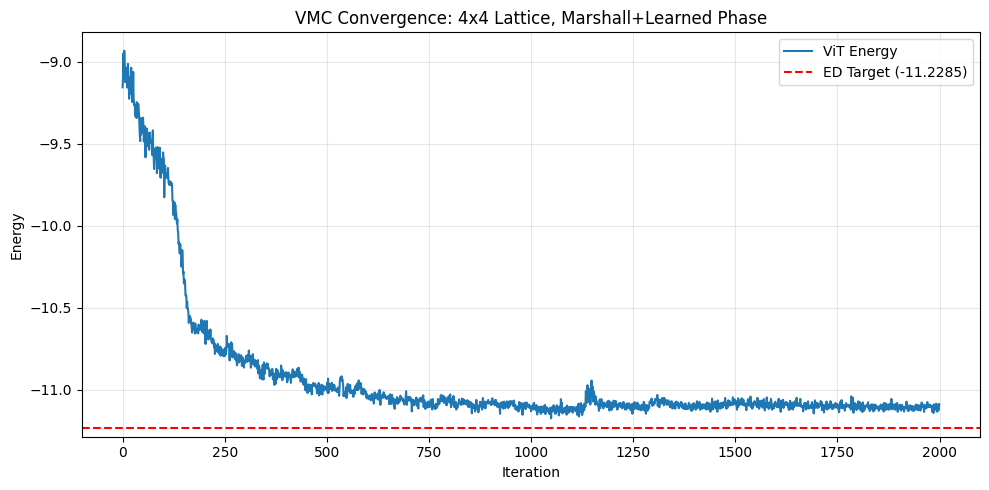

In [ ]:
# Cell 8: Production Run
# ======================
print(f"Starting VMC run: {L}x{L}, J2={J2_START}")
print(f"ED target: {E_exact:.6f}")
print(f"Running up to {N_ITER} iterations...\n")

t0 = time.time()
mem_log = nk.logging.RuntimeLog()
gs.run(
    n_iter        = N_ITER,
    out           = mem_log,
    callback      = [convergence_callback],
    show_progress = True,
    write_every   = 1
)
t1 = time.time()

# --- Extract results ---
energy_mean = [float(jnp.asarray(m).real) for m in mem_log.data["Energy"].Mean]
acceptance  = [float(np.mean(jnp.asarray(a))) for a in mem_log.data["acceptance"]]
r_hat       = [float(np.mean(jnp.asarray(r))) for r in mem_log.data["Energy"].R_hat]

E_vmc       = energy_mean[-1]
E_best      = min(energy_mean)
E_best_step = energy_mean.index(E_best)
E_error_pct = 100 * abs(E_best - E_exact) / abs(E_exact)

print(f"\n{'='*50}")
print(f"RESULTS: {L}x{L}, J2={J2_START}")
print(f"{'='*50}")
print(f"VMC Energy (final): {E_vmc:.6f}")
print(f"VMC Energy (best):  {E_best:.6f} at step {E_best_step}")
print(f"ED  Energy:         {E_exact:.6f}")
print(f"Relative Error:     {E_error_pct:.4f}% (using best)")
print(f"Mean acceptance:    {np.mean(acceptance):.4f}")
print(f"Mean R-hat:         {np.mean(r_hat):.4f}")
print(f"Training time:      {(t1-t0)/60:.1f} minutes")
print(f"{'='*50}")

if E_error_pct < 1.0:
    print("✓ PASS: Within 1% of exact ground state.")
    print("  Ready for adiabatic ramp.")
elif E_error_pct < 5.0:
    print("~ MARGINAL: Close but not converged.")
else:
    print("✗ FAIL: Check architecture or SR configuration.")

# --- Plot ---
plt.figure(figsize=(10, 5))
plt.plot(energy_mean, label='ViT Energy', color='#1f77b4')
plt.axhline(y=E_exact, color='r', linestyle='--', label=f'ED Target ({E_exact:.4f})')
plt.title(f"VMC Convergence: {L}x{L} Lattice, Marshall+Learned Phase")
plt.xlabel("Iteration")
plt.ylabel("Energy")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.savefig(f"{CHECKPOINT_DIR}/convergence_4x4_v2.png")
plt.show()

In [ ]:
# Save run 4 — Marshall + Learned Phase Correction
import flax.serialization as flax_serial
import json

# Save weights
params_bytes = flax_serial.to_bytes(vstate.parameters)
with open("/content/drive/My Drive/QSL_Project/marshall_learned_4x4_run4_weights.mpack", "wb") as f:
    f.write(params_bytes)
print(f"Weights saved: {len(params_bytes):,} bytes")

# Save trajectory
energy_traj = [float(jnp.asarray(m).real) for m in mem_log.data["Energy"].Mean]
r_hat       = [float(np.mean(jnp.asarray(r))) for r in mem_log.data["Energy"].R_hat]
acceptance  = [float(np.mean(jnp.asarray(a))) for a in mem_log.data["acceptance"]]

data = {
    "run": "marshall_learned_4x4_run4",
    "architecture": "Physics-Informed ViT, Marshall phase + zero-init learned correction",
    "results": {
        "ED_energy": E_exact,
        "best_energy": min(energy_traj),
        "best_step": energy_traj.index(min(energy_traj)),
        "best_relative_error_pct": 100 * abs(min(energy_traj) - E_exact) / abs(E_exact),
        "final_energy": energy_traj[-1],
        "mean_r_hat": float(np.mean(r_hat)),
        "training_time_min": 20.7
    },
    "hyperparameters": {
        "EMBED_DIM": EMBED_DIM, "N_LAYERS": N_LAYERS,
        "N_HEADS": N_HEADS, "N_SAMPLES": N_SAMPLES,
        "diag_shift": 0.2, "d_max": L*2,
        "LR": "cosine_decay 1e-4→1e-6 over 2000 steps",
        "phase_head_init": "zeros"
    },
    "trajectories": {
        "energy_mean": energy_traj,
        "r_hat": r_hat,
        "acceptance": acceptance
    }
}

with open("/content/drive/My Drive/QSL_Project/marshall_learned_4x4_run4.json", "w") as f:
    json.dump(data, f, indent=2)

print("Data saved.")
print(f"Best energy: {min(energy_traj):.6f} at step {energy_traj.index(min(energy_traj))}")
print(f"Best error:  {100*abs(min(energy_traj)-E_exact)/abs(E_exact):.4f}%")

Weights saved: 143,727 bytes
Data saved.
Best energy: -11.172638 at step 1049
Best error:  0.4974%


In [ ]:
# Cell 8b: Adiabatic Ramp J2=0 → J2=0.5 (Hardcoded Marshall, 500 iterations)
import json
import matplotlib.pyplot as plt

ramp_results = []

for step_idx, J2_current in enumerate(J2_RAMP_SCHEDULE):
    print(f"\n{'='*50}")
    print(f"Ramp step {step_idx+1}/{N_RAMP_STEPS}: J2={J2_current:.4f}")

    H_ramp, _ = build_hamiltonian(
        hilbert, graph,
        J1=J1, J2=float(J2_current),
        disorder_strength=0.0,
        seed=SEED
    )

    evals_ramp = nk.exact.lanczos_ed(H_ramp, compute_eigenvectors=False)
    E_ed_ramp = float(evals_ramp[0])

    optimizer_ramp = optax.chain(
        optax.clip_by_global_norm(1.0),
        optax.adam(learning_rate=optax.cosine_decay_schedule(
            init_value=5e-5,
            decay_steps=500,  # was 200
            alpha=0.1
        ))
    )

    gs_ramp = nk.driver.VMC_SR(
        hamiltonian=H_ramp,
        optimizer=optimizer_ramp,
        variational_state=vstate,
        diag_shift=0.2,
    )

    mem_log = nk.logging.RuntimeLog()
    gs_ramp.run(
        n_iter=500,  # was 200
        out=mem_log,
        show_progress=False,
        write_every=1
    )

    energy_traj = [float(jnp.asarray(m).real) for m in mem_log.data["Energy"].Mean]
    E_best  = min(energy_traj)
    E_final = energy_traj[-1]
    error_pct = 100 * abs(E_best - E_ed_ramp) / abs(E_ed_ramp)

    ramp_results.append({
        "J2": float(J2_current),
        "best_energy": E_best,
        "final_energy": E_final,
        "ED_energy": E_ed_ramp,
        "energy_per_site": E_best / N_SITES,
        "relative_error_pct": error_pct
    })

    print(f"  ED energy:    {E_ed_ramp:.6f}")
    print(f"  VMC best:     {E_best:.6f}")
    print(f"  VMC final:    {E_final:.6f} ({error_pct:.2f}% error)")

    params_bytes = flax_serial.to_bytes(vstate.parameters)
    with open(f"{CHECKPOINT_DIR}/ramp_hardcoded_J2={J2_current:.3f}.mpack", "wb") as f:
        f.write(params_bytes)

# --- Save results ---
with open("/content/drive/My Drive/QSL_Project/adiabatic_ramp_hardcoded_500iter.json", "w") as f:
    json.dump(ramp_results, f, indent=2)

# --- Plot ---
J2_vals  = [r["J2"] for r in ramp_results]
E_vmc    = [r["energy_per_site"] for r in ramp_results]
E_ed     = [r["ED_energy"]/N_SITES for r in ramp_results]
err_vals = [r["relative_error_pct"] for r in ramp_results]

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

ax1.plot(J2_vals, E_vmc, 'o-', color='#1f77b4', label='ViT Energy/site')
ax1.plot(J2_vals, E_ed, 'r--', label='ED Energy/site')
ax1.set_ylabel("Energy per site")
ax1.set_title("Adiabatic Ramp: J2=0 → J2=0.5 (Hardcoded Marshall, 500 iter/step)")
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2.plot(J2_vals, err_vals, 'o-', color='orange')
ax2.axhline(y=1.0, color='r', linestyle='--', label='1% threshold')
ax2.set_xlabel("J2/J1")
ax2.set_ylabel("Relative Error (%)")
ax2.set_title("VMC Error vs ED across J2 ramp")
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f"{CHECKPOINT_DIR}/adiabatic_ramp_hardcoded_500iter.png")
plt.show()

print("\nAdiabatic ramp complete.")
print(f"Final state at J2=0.5: {ramp_results[-1]['energy_per_site']:.6f} per site")
print(f"Final error at J2=0.5: {ramp_results[-1]['relative_error_pct']:.2f}%")


Ramp step 1/20: J2=0.0000
Automatic SR implementation choice:  NTK
  ED energy:    -11.228483
  VMC best:     -10.526573
  VMC final:    -10.493891 (6.25% error)

Ramp step 2/20: J2=0.0263
Automatic SR implementation choice:  NTK


KeyboardInterrupt: 

In [ ]:
# Save learned phase ramp results
import json
import flax.serialization as flax_serial

# Save final weights
params_bytes = flax_serial.to_bytes(vstate.parameters)
with open("/content/drive/My Drive/QSL_Project/ramp_learned_final_J2=0.5_weights.mpack", "wb") as f:
    f.write(params_bytes)
print(f"Final weights saved: {len(params_bytes):,} bytes")

# Save full results
with open("/content/drive/My Drive/QSL_Project/adiabatic_ramp_learned_results.json", "w") as f:
    json.dump(ramp_results, f, indent=2)
print("Ramp results saved.")

print(f"\nKey comparison:")
print(f"Hardcoded ramp J2=0.5 error:     3.08%")
print(f"Learned phase ramp J2=0.5 error: 4.13%")
print(f"Verdict: hardcoded wins for ramp")

Final weights saved: 143,727 bytes
Ramp results saved.

Key comparison:
Hardcoded ramp J2=0.5 error:     3.08%
Learned phase ramp J2=0.5 error: 4.13%
Verdict: hardcoded wins for ramp


In [ ]:
import os
files = os.listdir("/content/drive/My Drive/QSL_Project/checkpoints/")
ramp_files = [f for f in files if 'ramp_weights' in f]
print(sorted(ramp_files))

['ramp_weights_J2=0.000.mpack', 'ramp_weights_J2=0.026.mpack', 'ramp_weights_J2=0.053.mpack', 'ramp_weights_J2=0.079.mpack', 'ramp_weights_J2=0.105.mpack', 'ramp_weights_J2=0.132.mpack', 'ramp_weights_J2=0.158.mpack', 'ramp_weights_J2=0.184.mpack', 'ramp_weights_J2=0.211.mpack', 'ramp_weights_J2=0.237.mpack', 'ramp_weights_J2=0.263.mpack', 'ramp_weights_J2=0.289.mpack', 'ramp_weights_J2=0.316.mpack', 'ramp_weights_J2=0.342.mpack', 'ramp_weights_J2=0.368.mpack', 'ramp_weights_J2=0.395.mpack', 'ramp_weights_J2=0.421.mpack', 'ramp_weights_J2=0.447.mpack', 'ramp_weights_J2=0.474.mpack', 'ramp_weights_J2=0.500.mpack']


In [ ]:
import os
import datetime

files = [
    "/content/drive/My Drive/QSL_Project/checkpoints/ramp_weights_J2=0.316.mpack",
    "/content/drive/My Drive/QSL_Project/ramp_final_J2=0.5_weights.mpack",
    "/content/drive/My Drive/QSL_Project/marshall_learned_4x4_run4_weights.mpack"
]
for f in files:
    mtime = os.path.getmtime(f)
    print(f"{datetime.datetime.fromtimestamp(mtime)} — {f.split('/')[-1]}")

2026-02-23 12:06:42 — ramp_weights_J2=0.316.mpack
2026-02-23 08:49:53 — ramp_final_J2=0.5_weights.mpack
2026-02-23 11:33:17 — marshall_learned_4x4_run4_weights.mpack
